# V-ZUG Recipes exploration

We got an interesting database of recipes to play with at the [Open Food Data](https://food.opendata.ch) Hackathon hosted by V-Zug. The recipes are used to program smart kitchen devices. 

Let's have a look at this data, and see if we can mold it into a simpler form. In this notebook we are using plain Python 3 with the built-in [ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) functions.

We have also written a `convert.py` script to generate JSON files according to a schema defined in `recipe.py`. See example usage at the bottom.

In [1]:
import xml.etree.ElementTree as ET

Let's load up a recipe - if the XML is well formed we won't get any errors here:

In [2]:
tree = ET.parse('recipes/vzug.09.zupfkuchen/recipe.xml')
root = tree.getroot()

A basic check is the identifier of the recipe, and should match the filename.

In [3]:
root.find('declarations/uid').text

'vzug.09.zupfkuchen'

Check. Now that we know something about the data, let's take a peek inside.

In [4]:
root.find('.//image').attrib['id']

'vzug.09.zupfkuchen.slide'

Unfortunately, that image doesn't help much..

In [5]:
[ e.text for e in root.findall('declarations/name/lang') ]

['Zupfkuchen', 'Cheesecake', 'Gâteau au fromage blanc', 'Torta pizzicotta']

Okay, we are getting somewhere - let us see what else is there to learn about this tasty Cheesecake. How about the ingredients. How many are there?

In [6]:
ingredients = root.findall('declarations/ingredient-categories/cat')
len(ingredients)

15

Okay, and what are their names?

In [7]:
", ".join([ e.find('name/lang[@ref="en"]').text for e in ingredients ])

'soft butter, sugar, eggs, white flour, unsweetened cocoa powder, baking powder, soft butter, sugar, vanilla sugar, egg yolks, low-fat quark, full-fat quark, Maizena (cornflour), Cognac, egg whites'

All of them have identifiers. Some of them have units.

In [8]:
dict_ingredients = {}
for e in ingredients:
    ident = e.attrib["id"]
    unit = e.find('unit/lang[@ref="en"]').text
    name = e.find('name/lang[@ref="en"]').text
    if unit: print((ident, name, unit))
    dict_ingredients[ident] = {"name": name, "unit": unit}

('2649894283', 'soft butter', 'g')
('2649905291', 'sugar', 'g')
('2649925131', 'white flour', 'g')
('2649936139', 'unsweetened cocoa powder', 'g')
('2649947147', 'baking powder', 'packet of')
('2649984779', 'soft butter', 'g')
('2649995787', 'sugar', 'g')
('2650006795', 'vanilla sugar', 'packets of')
('2650026635', 'low-fat quark', 'g')
('2650037643', 'full-fat quark', 'g')
('2650048651', 'Maizena (cornflour)', 'g')
('2650059659', 'Cognac', 'tbsp')


Now that we know something about the ingredients, we can start <s>the robot</s> cooking. We should take it one step at a time. There are multiple "groups" under `task`, which each have multiple ingredients and messages underneath.

In [9]:
a_group = root.find('task/group')
[ m.text for m in a_group.findall('message/lang[@ref="en"]') ]

['Beat the butter and sugar together to give a light, fluffy mixture, add the eggs then continue to beat until you achieve a creamy consistency. Mix the flour, cocoa powder and baking powder together and fold into the butter mixture. Leave the dough in a cool place for 2 hours.',
 'Grease the base and side of the spring form tin with butter. Divide the dough into 2 equal portions. Roll one portion out across the base of the spring form tin. Place the ring on top. Divide the remaining dough into 2 equal portions, then roll one portion out so that it is the same length as the circumference of the tin, place it on the dough base around the edge of the tin and shape to a height of around 6 cm.']

Sometimes the messages target a particular device.

In [10]:
root.find('task/group/message[scope]/lang[@ref="en"]').text

'Put the tin on to the wire shelf at level 2 of the preheated cooking space. Hot air 160 °C, 70 minutes.'

These scoped messages reference device models:

In [11]:
[ d.attrib['device-ref'] for d in root.findall('task/group/message/scope') ]

['CS-S-12', 'CS-S-09', 'CST-SL-12', 'CST-SL-09', 'CST-XSL-12', 'CST-XSL-09']

..which the recipe does summarize, but does not provide product information for.

In [12]:
[ d.attrib['id'] for d in root.findall('declarations/devices/device') ]

['CST-SL-09', 'CST-SL-12', 'CST-XSL-09', 'CST-XSL-12', 'CS-S-09', 'CS-S-12']

The really cool (no pun intended) part is when cooking instructions are mentioned, e.g.:

In [13]:
a_command = root.findall('task/group/device-command/oven[@oven-temperature]')[1]
(a_command.attrib['duration'], 
 a_command.attrib['heating-mode'], 
 a_command.attrib['oven-temperature'],
 a_command.find('continue').attrib['condition']
)

('01:10:00', '002-hot-air', '160', 'Einschaltdauer')

And of course, the amounts of ingredients to use:

In [14]:
print(a_group.find('title/lang[@ref="en"]').text)
for e in a_group.findall('ingredient'):
    d = dict_ingredients[e.attrib['ref']]
    d['amount'] = int(e.find('amount').attrib["min"])
    print(d)

Dough
{'name': 'soft butter', 'unit': 'g', 'amount': 200}
{'name': 'sugar', 'unit': 'g', 'amount': 200}
{'name': 'eggs', 'unit': None, 'amount': 2}
{'name': 'white flour', 'unit': 'g', 'amount': 400}
{'name': 'unsweetened cocoa powder', 'unit': 'g', 'amount': 50}
{'name': 'baking powder', 'unit': 'packet of', 'amount': 1}


It may also help the app developer to categorize this recipe:

In [15]:
categories = root.find('.//categories')
[ e.attrib["path"] for e in categories.findall('category') ]

['/calories/high',
 '/cooking-skill/advanced',
 '/duration/medium',
 '/main-ingredient/dairy-product',
 '/producing-country/Switzerland',
 '/allergy/gluten',
 '/allergy/milk',
 '/allergy/egg',
 '/allergy/sulphite',
 '/diet/vegetarian',
 '/dish-type/cake',
 '/menu/dessert',
 '/occasion/guests',
 '/religion/alcohol']

And the total cooking time (for some reason the elements have duplicates in the XML)

In [16]:
print("Preparation: %s" % categories.find('duration[@type="preparation"]').attrib["value"])
print("Cooking: %s" % categories.find('duration[@type="cooking"]').attrib["value"])

Preparation: 02:30:00
Cooking: 01:10:00


Another thing of note is the list of equipment (tools?) required.

In [17]:
[ e.text for e in root.findall('task/group[@type="equipment"]/*/lang[@ref="en"]') ]

['Accessories', 'Spring form tin ø26 cm', 'Wire shelf']

Putting it together, let's see if we can put the essential bits of the recipe into a dictionary.

In [18]:
from recipe import Recipe

LANGUAGES = ['de', 'en', 'fr', 'it']

Recipe(root, 'en').dict()

{'id': 'vzug.09.zupfkuchen',
 'name': 'Cheesecake',
 'categories': {'calories': ['high'],
  'cooking-skill': ['advanced'],
  'duration': ['medium'],
  'main-ingredient': ['dairy-product'],
  'producing-country': ['Switzerland'],
  'allergy': ['gluten', 'milk', 'egg', 'sulphite'],
  'diet': ['vegetarian'],
  'dish-type': ['cake'],
  'menu': ['dessert'],
  'occasion': ['guests'],
  'religion': ['alcohol']},
 'preparationTime': '02:30:00',
 'cookingTime': '01:10:00',
 'ingredients': ['soft butter',
  'sugar',
  'eggs',
  'white flour',
  'unsweetened cocoa powder',
  'baking powder',
  'soft butter',
  'sugar',
  'vanilla sugar',
  'egg yolks',
  'low-fat quark',
  'full-fat quark',
  'Maizena (cornflour)',
  'Cognac',
  'egg whites'],
 'instructions': {0: {'title': 'Dough',
   'message': 'Beat the butter and sugar together to give a light, fluffy mixture, add the eggs then continue to beat until you achieve a creamy consistency. Mix the flour, cocoa powder and baking powder together and 

Or we can load all the data at once and do some basic analysis.

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
dirlist = [dirs for root, dirs, files in os.walk('recipes')]
df = pd.DataFrame(columns=['name', 'ingredients', 'instructions', 'skill', 'duration'])

for subdir in dirlist[0]:
    tree = ET.parse('recipes/%s/recipe.xml' % subdir)
    root = tree.getroot()
    data = Recipe(root, 'en').dict()

    df = df.append({
        'name':          data['name'],
        'ingredients':   len(data['ingredients']),
        'instructions':  len(data['instructions']),
        'skill':         data['categories']['cooking-skill'][0],
        'duration':      data['categories']['duration'][0],
    }, ignore_index=True)
    
df.head()

,name,ingredients,instructions,skill,duration
0,"Mozzarella, green bean and onion mash",8,2,easy,fast
1,Apple puff pastry horseshoes,6,5,easy,medium
2,Tarte Tatin,4,2,moderate,medium
3,Mashed potato with lime,4,3,easy,fast
4,Duck breast with a honey and soy glaze and plu...,16,3,moderate,medium


<Figure size 432x288 with 0 Axes>

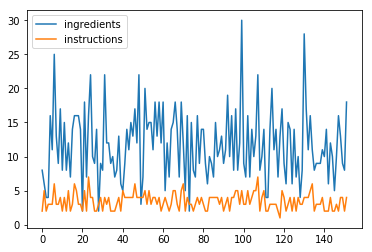

In [24]:
plt.figure(); df.plot(); plt.legend(loc='best')